# Segmentación

En esta lección aprenderemos sobre "segmentación". Segmentación significa dividir los pixeles de una imagen en las componentes de las cuales forma parte. Por ejemplo, carro, perro, etc.

Esta lección está basada completamente en el [curso que dan los de fast.ai](https://course.fast.ai/), todo el crédito de ellos.


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai.basics as fai
import fastai.vision as fv
import fastai.callbacks.hooks as fch
import numpy as np
from pathlib import Path
import gc

## Datos

Usaremos los datos "camvid" que ya vienen con fastai. Son imágenes tomadas por cámaras de carros y segmentadas manualmente (como para hacer self-driving cars).

In [3]:
path = fai.untar_data(fai.URLs.CAMVID)

In [4]:
path.ls()

[PosixPath('/home/mraggi/.fastai/data/camvid/images'),
 PosixPath('/home/mraggi/.fastai/data/camvid/codes.txt'),
 PosixPath('/home/mraggi/.fastai/data/camvid/valid.txt'),
 PosixPath('/home/mraggi/.fastai/data/camvid/models'),
 PosixPath('/home/mraggi/.fastai/data/camvid/labels')]

In [5]:
images = (path/"images").ls()
labels = (path/"labels").ls()

In [58]:
labels[:5]

[PosixPath('/home/mraggi/.fastai/data/camvid/labels/0016E5_08001_P.png'),
 PosixPath('/home/mraggi/.fastai/data/camvid/labels/0001TP_010320_P.png'),
 PosixPath('/home/mraggi/.fastai/data/camvid/labels/0016E5_00630_P.png'),
 PosixPath('/home/mraggi/.fastai/data/camvid/labels/0001TP_007950_P.png'),
 PosixPath('/home/mraggi/.fastai/data/camvid/labels/0016E5_08089_P.png')]

In [60]:
!cat {path}/valid.txt | head

0016E5_07959.png
0016E5_07961.png
0016E5_07963.png
0016E5_07965.png
0016E5_07967.png
0016E5_07969.png
0016E5_07971.png
0016E5_07973.png
0016E5_07975.png
0016E5_07977.png


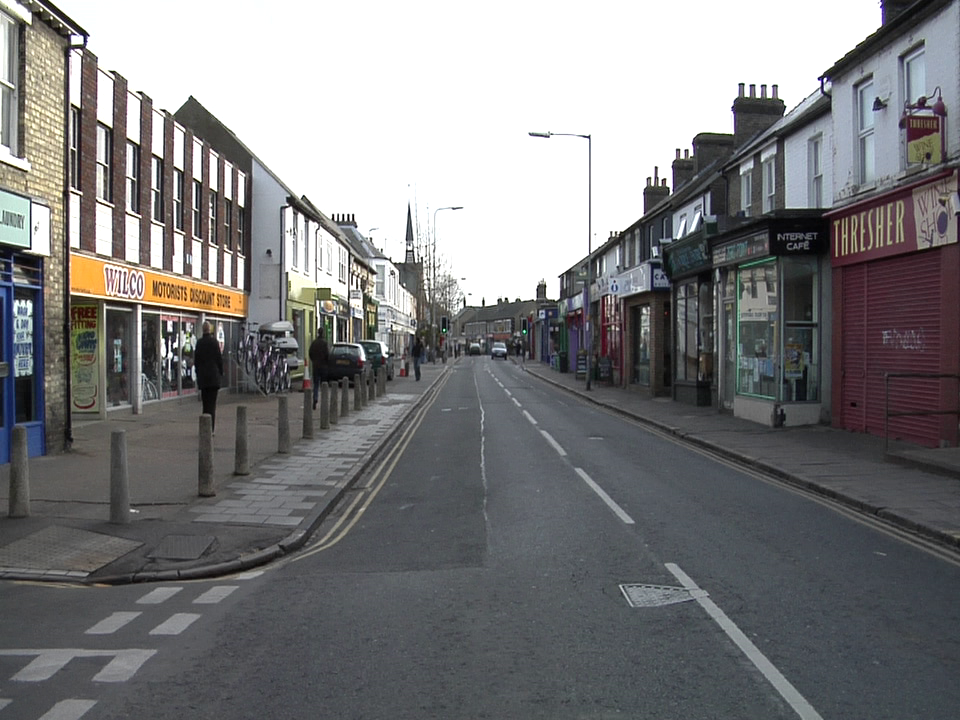

In [6]:
img_file = images[0]
img = fv.open_image(img_file)
img

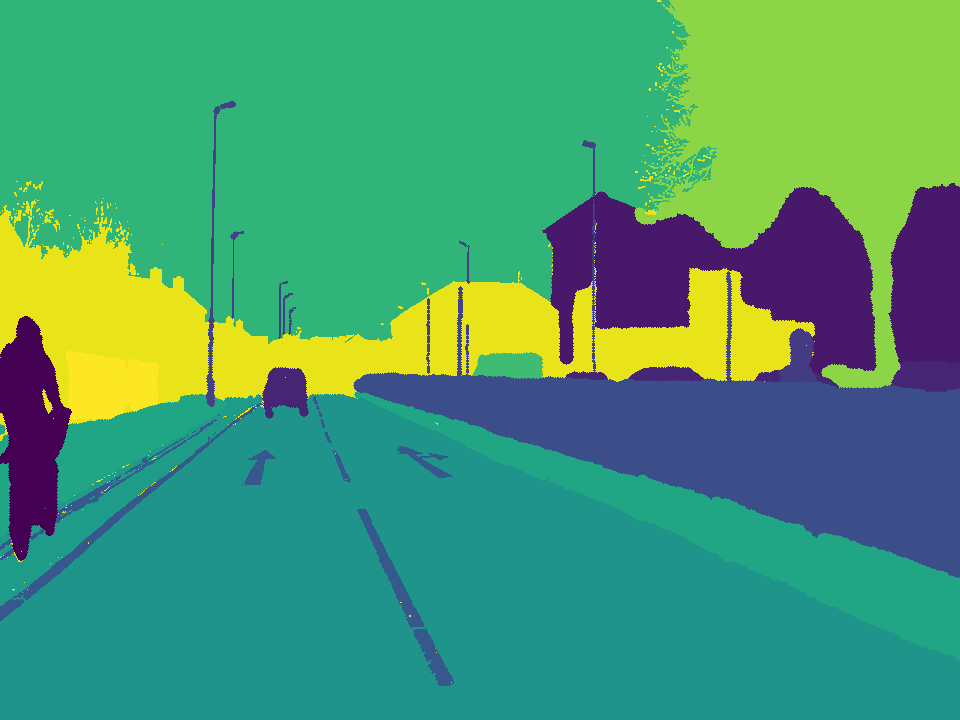

In [56]:
img_file = labels[2]
img = fv.open_mask(img_file) # cambia por "open_mask"
img

In [8]:
def get_label(x):
    return path/'labels'/f'{x.stem}_P{x.suffix}'

In [9]:
!cat {path/'codes.txt'}

Animal
Archway
Bicyclist
Bridge
Building
Car
CartLuggagePram
Child
Column_Pole
Fence
LaneMkgsDriv
LaneMkgsNonDriv
Misc_Text
MotorcycleScooter
OtherMoving
ParkingBlock
Pedestrian
Road
RoadShoulder
Sidewalk
SignSymbol
Sky
SUVPickupTruck
TrafficCone
TrafficLight
Train
Tree
Truck_Bus
Tunnel
VegetationMisc
Void
Wall


In [10]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [62]:
codes[2]

'Bicyclist'

In [11]:
size = np.array(img.shape[1:]); size

array([720, 960])

In [12]:
def load_data(img_size, batch_size):
    tfms = fv.get_transforms()
    data = (fv.SegmentationItemList
            .from_folder(path/"images")
            .split_by_fname_file(path/"valid.txt")
            .label_from_func(get_label, classes=codes)
            .transform(tfms, size=img_size, tfm_y=True)
            .databunch(bs=batch_size)
            .normalize(fv.imagenet_stats))
    return data

In [13]:
data = load_data(size//2, 4)

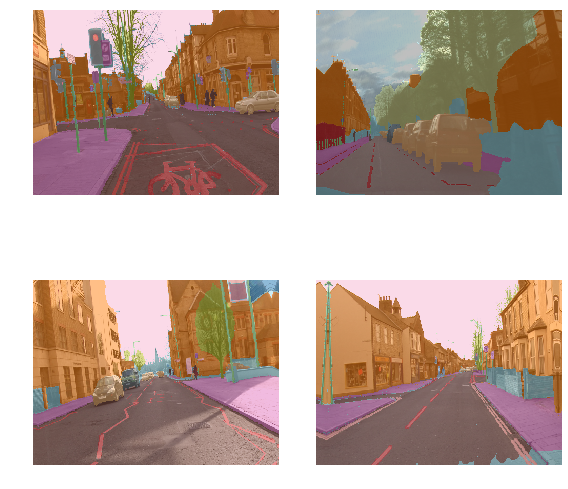

In [14]:
data.show_batch(2)

In [15]:
name2id = {v:k for k,v in enumerate(codes)}

In [16]:
name2id

{'Animal': 0,
 'Archway': 1,
 'Bicyclist': 2,
 'Bridge': 3,
 'Building': 4,
 'Car': 5,
 'CartLuggagePram': 6,
 'Child': 7,
 'Column_Pole': 8,
 'Fence': 9,
 'LaneMkgsDriv': 10,
 'LaneMkgsNonDriv': 11,
 'Misc_Text': 12,
 'MotorcycleScooter': 13,
 'OtherMoving': 14,
 'ParkingBlock': 15,
 'Pedestrian': 16,
 'Road': 17,
 'RoadShoulder': 18,
 'Sidewalk': 19,
 'SignSymbol': 20,
 'Sky': 21,
 'SUVPickupTruck': 22,
 'TrafficCone': 23,
 'TrafficLight': 24,
 'Train': 25,
 'Tree': 26,
 'Truck_Bus': 27,
 'Tunnel': 28,
 'VegetationMisc': 29,
 'Void': 30,
 'Wall': 31}

In [17]:
void_code = name2id['Void']

Según el paper, las "void" no cuentan para la accuracy. Así que tenemos que hacer nuestra propia función de accuracy.

In [18]:
def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = (target != void_code)
    return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

Usaremos un modelo llamado "unet" para hacer segmentación. La idea del modelo es que primero "comprime" la imagen (en este caso con resnet34) y luego la descomprime, PERO cada que salta en tamaño arriba tiene acceso a la información que tenía al pasar hacia abajo. Ver [el paper original](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/).

![Unet](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [19]:
learn = fv.unet_learner(data, fv.models.resnet34, metrics=acc_camvid, wd=1e-2, bottle=True)

In [63]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [1, 64, 360, 480]    9,408      True      
______________________________________________________________________
BatchNorm2d          [1, 64, 360, 480]    128        True      
______________________________________________________________________
ReLU                 [1, 64, 360, 480]    0          False     
______________________________________________________________________
MaxPool2d            [1, 64, 180, 240]    0          False     
______________________________________________________________________
Conv2d               [1, 64, 180, 240]    36,864     True      
______________________________________________________________________
BatchNorm2d          [1, 64, 180, 240]    128        True      
______________________________________________________________________
ReLU                 [1, 64, 180, 240]    0          False     
______________________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-04


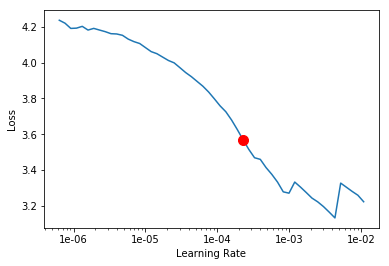

In [21]:
learn.lr_find(); learn.recorder.plot()

In [ ]:
fai.Pixe

In [22]:
learn.fit_one_cycle(10, slice(1e-3), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,1.140579,0.877253,0.788727
2,0.780622,0.647861,0.833173
3,0.627596,0.524222,0.857154
4,0.596364,0.540248,0.853311
5,0.612738,0.706375,0.820523
6,0.569768,0.470188,0.862021
7,0.530942,0.471698,0.872866
8,0.477343,0.371095,0.892022
9,0.435305,0.331611,0.902284
10,0.345156,0.302556,0.912644


In [23]:
learn.save('stage-1')

In [24]:
gc.collect()

14455

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-06


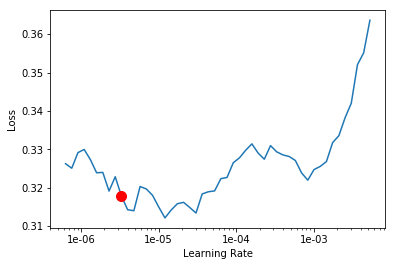

In [25]:
learn.lr_find(); learn.recorder.plot()

In [26]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07


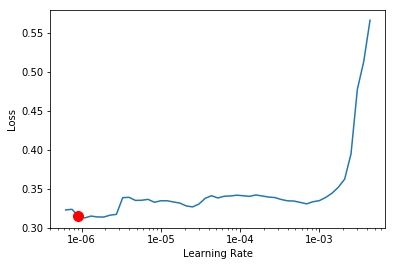

In [27]:
learn.lr_find(); learn.recorder.plot()

In [28]:
learn.fit_one_cycle(12, slice(5e-6,3e-4), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.326551,0.290898,0.916322
2,0.321211,0.290883,0.917124
3,0.314164,0.287250,0.917045
4,0.309376,0.288147,0.917592
5,0.306968,0.279932,0.920318
6,0.303540,0.298901,0.911167
7,0.293924,0.268183,0.922321
8,0.299797,0.284889,0.919610
9,0.291134,0.278649,0.918546
10,0.275198,0.267780,0.922325


In [29]:
learn.save('stage-2_93');

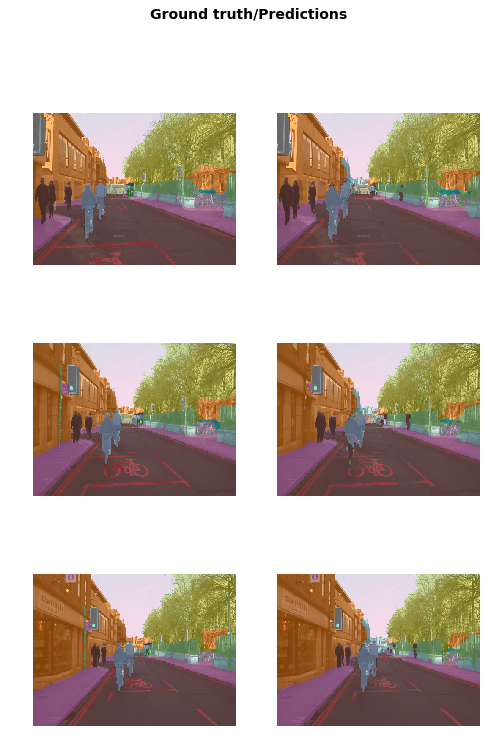

In [30]:
learn.show_results(rows=3)

## Entrenar a lo grande!

Estábamos entrenando con la mitad de tamaño. Ahora entrenaremos con tamaño completo!

In [36]:
learn.data = load_data(img_size=size, batch_size=1)

In [37]:
gc.collect()

56

In [38]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


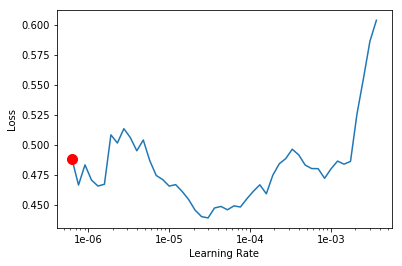

In [39]:
learn.lr_find(); learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(4, slice(8e-6,1e-4), pct_start=0.6)

epoch,train_loss,valid_loss,acc_camvid
1,0.384667,0.314813,0.913049
2,0.365228,0.275708,0.920535


In [43]:
learn.save('stage-1-big')

In [45]:
learn.validate()

[0.27713886, tensor(0.9223)]

In [ ]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


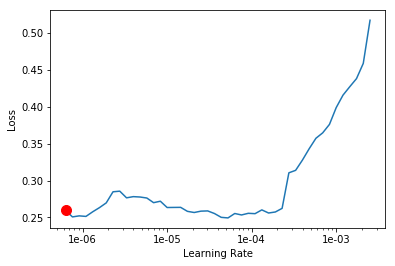

In [46]:
learn.lr_find(); learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(8, slice(5e-6,3e-4), pct_start=0.6)

In [ ]:
learn.show_results(rows=3)